# Text and Sequence Assignment4

**Downloading and Preparing the IMDB Dataset**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5768k      0  0:00:14  0:00:14 --:--:-- 12.7M


**Preprocessing the Text Data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir= pathlib.Path("/content/aclImdb")
val_dir = base_dir/ "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True )

    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

val_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
).take(10000)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Vectorizing the Text Sequences**

In [3]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Baseline Model: One-Hot Encoded Vectors**

In [4]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

**One Hot Model**

Epoch 1/10
100/100 [==============================] - 25s 201ms/step - loss: 0.6923 - accuracy: 0.5203 - val_loss: 0.6899 - val_accuracy: 0.5780
Epoch 2/10
100/100 [==============================] - 16s 166ms/step - loss: 0.6413 - accuracy: 0.6463 - val_loss: 0.5929 - val_accuracy: 0.6990
Epoch 3/10
100/100 [==============================] - 6s 65ms/step - loss: 0.5122 - accuracy: 0.7825 - val_loss: 0.6595 - val_accuracy: 0.7234
Epoch 4/10
100/100 [==============================] - 17s 166ms/step - loss: 0.3961 - accuracy: 0.8497 - val_loss: 0.4821 - val_accuracy: 0.7684
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.3231 - accuracy: 0.8934 - val_loss: 0.4929 - val_accuracy: 0.7526
Epoch 6/10
100/100 [==============================] - 6s 62ms/step - loss: 0.2650 - accuracy: 0.9116 - val_loss: 0.6802 - val_accuracy: 0.7214
Epoch 7/10
100/100 [==============================] - 16s 166ms/step - loss: 0.2292 - accuracy: 0.9206 - val_loss: 0.4809 - val_accuracy

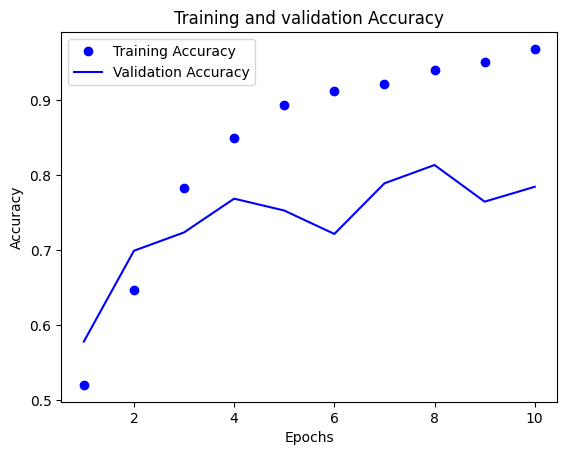

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.x",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("one_hot_bidir_lstm.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Developing the Embedding Layer**


In [6]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**Model with Trainable Embedding Layer**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

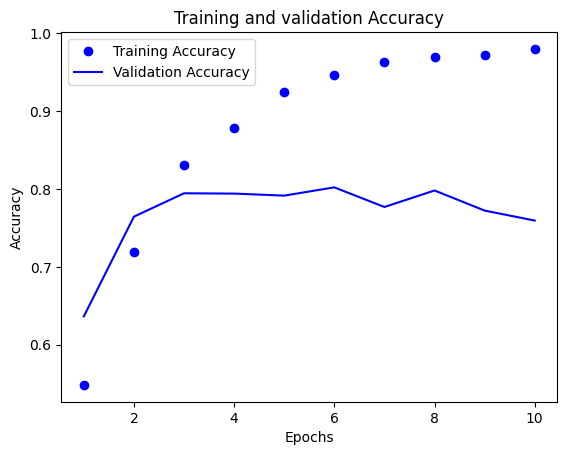

In [7]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs,accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Masking Padded Sequences in the Embedding Layer**

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

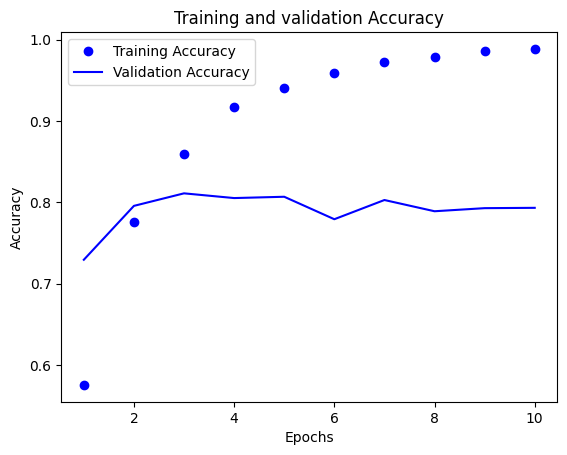

In [8]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Using Pre-trained Word Embeddings (GloVe)**

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-05 20:24:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-05 20:24:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-05 20:24:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Reading Glove Data**

In [10]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Setting Matrix for Glove Words**

In [11]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model with Pretrained GloVe Embeddings**

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

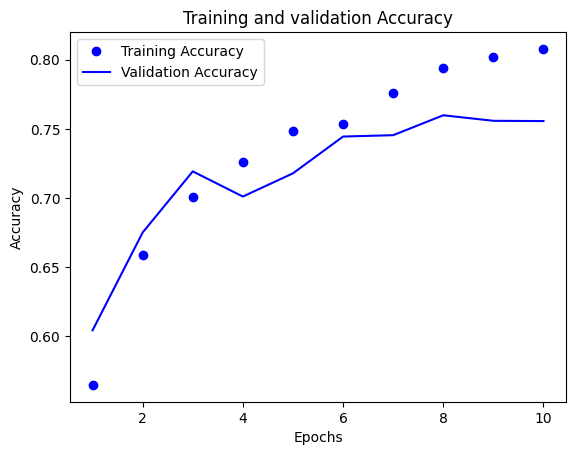

In [13]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Comparing Model Performance with Different Training Set Sizes**

Found 20000 files belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 32s 249ms/step - loss: 0.6874 - accuracy: 0.5253 - val_loss: 0.6515 - val_accuracy: 0.6452
Epoch 2/10
100/100 [==============================] - 22s 221ms/step - loss: 0.5658 - accuracy: 0.7347 - val_loss: 0.5902 - val_accuracy: 0.7132
Epoch 3/10
100/100 [==============================] - 15s 147ms/step - loss: 0.4248 - accuracy: 0.8363 - val_loss: 0.5746 - val_accuracy: 0.7664
Epoch 4/10
100/100 [==============================] - 18s 186ms/step - loss: 0.3156 - accuracy: 0.8850 - val_loss: 0.4597 - val_accuracy: 0.7944
Epoch 5/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2063 - accuracy: 0.9287 - val_loss: 0.6980 - val_accuracy: 0.7626
Epoch 6/10
100/100 [==============================] - 7s 69ms/step - loss: 0.1534 - accuracy: 0.9488 - val_loss: 0.4957 - val_accuracy: 0.8034
Epoch 7/10
100/100 [==============================] - 5s 50ms/step - loss: 0.1161 - accuracy

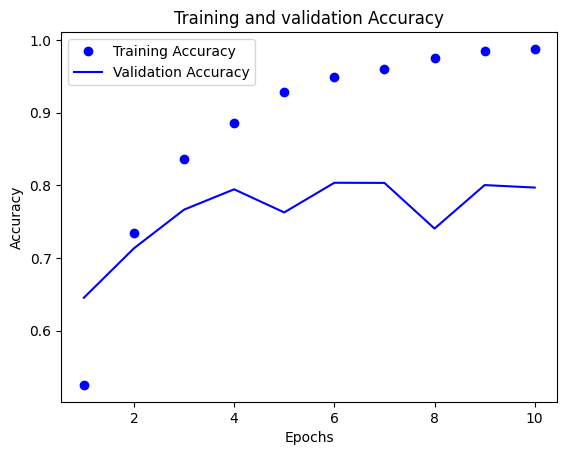

Epoch 1/10
100/100 [==============================] - 44s 332ms/step - loss: 0.6845 - accuracy: 0.5587 - val_loss: 0.6520 - val_accuracy: 0.6294
Epoch 2/10
100/100 [==============================] - 35s 349ms/step - loss: 0.6348 - accuracy: 0.6375 - val_loss: 0.6060 - val_accuracy: 0.6736
Epoch 3/10
100/100 [==============================] - 33s 330ms/step - loss: 0.5910 - accuracy: 0.6809 - val_loss: 0.5536 - val_accuracy: 0.7354
Epoch 4/10
100/100 [==============================] - 10s 98ms/step - loss: 0.5549 - accuracy: 0.7250 - val_loss: 0.6530 - val_accuracy: 0.6498
Epoch 5/10
100/100 [==============================] - 42s 418ms/step - loss: 0.5213 - accuracy: 0.7387 - val_loss: 0.5009 - val_accuracy: 0.7614
Epoch 6/10
100/100 [==============================] - 5s 48ms/step - loss: 0.5002 - accuracy: 0.7572 - val_loss: 0.5209 - val_accuracy: 0.7422
Epoch 7/10
100/100 [==============================] - 32s 318ms/step - loss: 0.4753 - accuracy: 0.7697 - val_loss: 0.4848 - val_accur

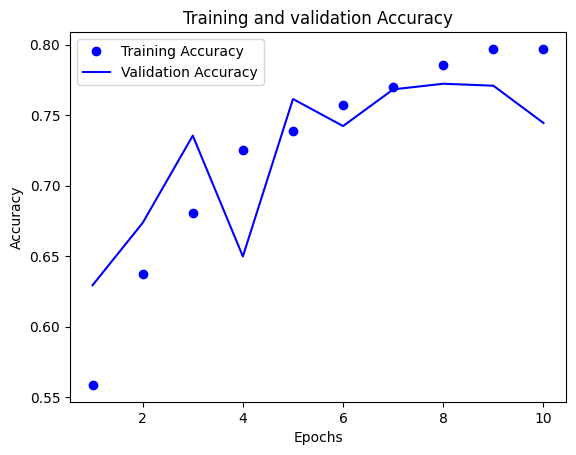

Training samples: 100
Embedding layer test accuracy: 0.789
Pretrained embeddings test accuracy: 0.775
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 50s 89ms/step - loss: 0.5362 - accuracy: 0.7259 - val_loss: 0.4049 - val_accuracy: 0.8230
Epoch 2/10
500/500 [==============================] - 28s 56ms/step - loss: 0.3627 - accuracy: 0.8549 - val_loss: 0.3829 - val_accuracy: 0.8330
Epoch 3/10
500/500 [==============================] - 27s 53ms/step - loss: 0.2977 - accuracy: 0.8863 - val_loss: 0.3720 - val_accuracy: 0.8382
Epoch 4/10
500/500 [==============================] - 13s 27ms/step - loss: 0.2517 - accuracy: 0.9043 - val_loss: 0.3731 - val_accuracy: 0.8398
Epoch 5/10
500/500 [==============================] - 18s 35ms/step - loss: 0.2274 - accuracy: 0.9159 - val_loss: 0.4701 - val_accuracy: 0.7808
Epoch 6/10
500/500 [==============================] - 13s 25ms/step - loss: 0.2053 - 

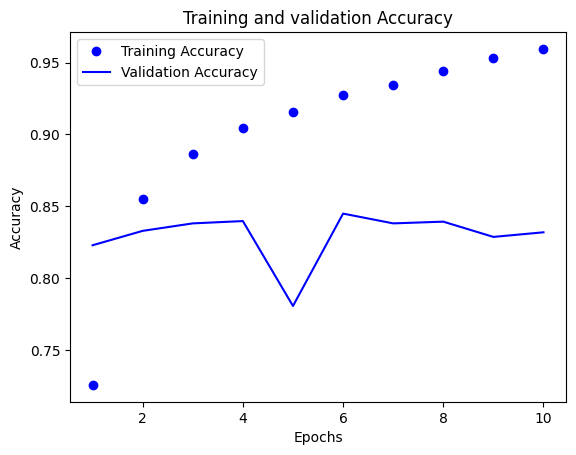

Epoch 1/10
500/500 [==============================] - 65s 110ms/step - loss: 0.6142 - accuracy: 0.6569 - val_loss: 0.5141 - val_accuracy: 0.7532
Epoch 2/10
500/500 [==============================] - 46s 92ms/step - loss: 0.5095 - accuracy: 0.7564 - val_loss: 0.4610 - val_accuracy: 0.7784
Epoch 3/10
500/500 [==============================] - 47s 94ms/step - loss: 0.4614 - accuracy: 0.7842 - val_loss: 0.4580 - val_accuracy: 0.7794
Epoch 4/10
500/500 [==============================] - 46s 93ms/step - loss: 0.4317 - accuracy: 0.8017 - val_loss: 0.4253 - val_accuracy: 0.8038
Epoch 5/10
500/500 [==============================] - 46s 93ms/step - loss: 0.4098 - accuracy: 0.8162 - val_loss: 0.3957 - val_accuracy: 0.8214
Epoch 6/10
500/500 [==============================] - 48s 96ms/step - loss: 0.3915 - accuracy: 0.8260 - val_loss: 0.3908 - val_accuracy: 0.8226
Epoch 7/10
500/500 [==============================] - 15s 29ms/step - loss: 0.3742 - accuracy: 0.8372 - val_loss: 0.4012 - val_accuracy

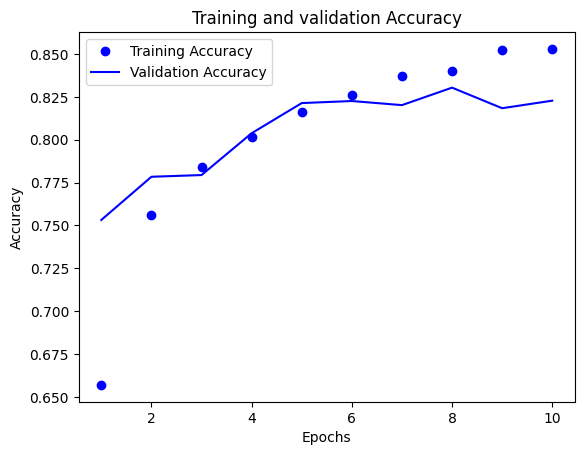

Training samples: 500
Embedding layer test accuracy: 0.828
Pretrained embeddings test accuracy: 0.825
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 57s 83ms/step - loss: 0.5332 - accuracy: 0.7164 - val_loss: 0.3814 - val_accuracy: 0.8302
Epoch 2/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3554 - accuracy: 0.8525 - val_loss: 0.3560 - val_accuracy: 0.8446
Epoch 3/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3024 - accuracy: 0.8802 - val_loss: 0.3681 - val_accuracy: 0.8530
Epoch 4/10
625/625 [==============================] - 18s 28ms/step - loss: 0.2638 - accuracy: 0.8969 - val_loss: 0.3847 - val_accuracy: 0.8544
Epoch 5/10
625/625 [==============================] - 16s 26ms/step - loss: 0.2396 - accuracy: 0.9119 - val_loss: 0.3718 - val_accuracy: 0.8576
Epoch 6/10
625/625 [==============================] - 20s 32ms/step - loss: 0.2055 - 

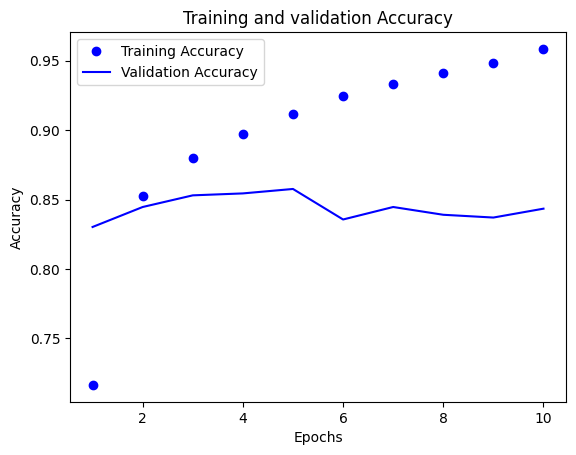

Epoch 1/10
625/625 [==============================] - 66s 94ms/step - loss: 0.6005 - accuracy: 0.6678 - val_loss: 0.5177 - val_accuracy: 0.7474
Epoch 2/10
625/625 [==============================] - 18s 28ms/step - loss: 0.4907 - accuracy: 0.7661 - val_loss: 0.5948 - val_accuracy: 0.7226
Epoch 3/10
625/625 [==============================] - 50s 80ms/step - loss: 0.4474 - accuracy: 0.7932 - val_loss: 0.4179 - val_accuracy: 0.8050
Epoch 4/10
625/625 [==============================] - 60s 96ms/step - loss: 0.4198 - accuracy: 0.8083 - val_loss: 0.4026 - val_accuracy: 0.8106
Epoch 5/10
625/625 [==============================] - 47s 74ms/step - loss: 0.3957 - accuracy: 0.8246 - val_loss: 0.3892 - val_accuracy: 0.8208
Epoch 6/10
625/625 [==============================] - 48s 77ms/step - loss: 0.3775 - accuracy: 0.8339 - val_loss: 0.3741 - val_accuracy: 0.8292
Epoch 7/10
625/625 [==============================] - 47s 76ms/step - loss: 0.3616 - accuracy: 0.8407 - val_loss: 0.3740 - val_accuracy:

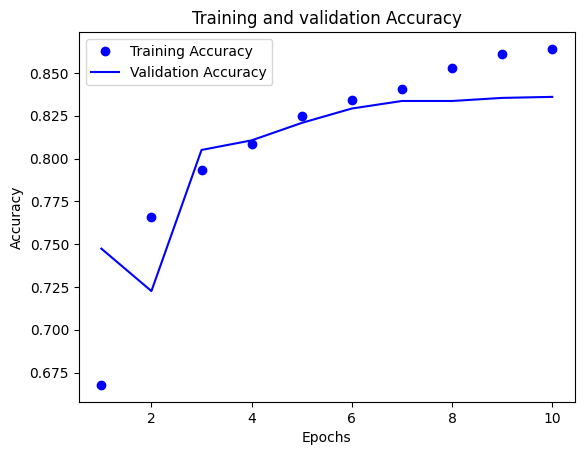

Training samples: 1000
Embedding layer test accuracy: 0.837
Pretrained embeddings test accuracy: 0.838
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 48s 69ms/step - loss: 0.5195 - accuracy: 0.7322 - val_loss: 0.3742 - val_accuracy: 0.8352
Epoch 2/10
625/625 [==============================] - 38s 60ms/step - loss: 0.3474 - accuracy: 0.8587 - val_loss: 0.3535 - val_accuracy: 0.8460
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2960 - accuracy: 0.8857 - val_loss: 0.3630 - val_accuracy: 0.8500
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2563 - accuracy: 0.9017 - val_loss: 0.4089 - val_accuracy: 0.8210
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2319 - accuracy: 0.9135 - val_loss: 0.4178 - val_accuracy: 0.8384
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2073 -

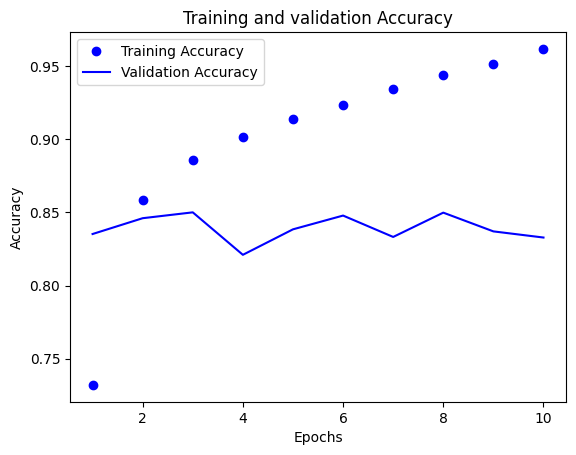

Epoch 1/10
625/625 [==============================] - 63s 84ms/step - loss: 0.6013 - accuracy: 0.6659 - val_loss: 0.6257 - val_accuracy: 0.6932
Epoch 2/10
625/625 [==============================] - 58s 93ms/step - loss: 0.4827 - accuracy: 0.7739 - val_loss: 0.4402 - val_accuracy: 0.7954
Epoch 3/10
625/625 [==============================] - 49s 79ms/step - loss: 0.4426 - accuracy: 0.7965 - val_loss: 0.4129 - val_accuracy: 0.8116
Epoch 4/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4147 - accuracy: 0.8126 - val_loss: 0.4109 - val_accuracy: 0.8114
Epoch 5/10
625/625 [==============================] - 17s 26ms/step - loss: 0.3921 - accuracy: 0.8274 - val_loss: 0.4202 - val_accuracy: 0.8120
Epoch 6/10
625/625 [==============================] - 48s 76ms/step - loss: 0.3753 - accuracy: 0.8335 - val_loss: 0.3949 - val_accuracy: 0.8250
Epoch 7/10
625/625 [==============================] - 54s 86ms/step - loss: 0.3591 - accuracy: 0.8421 - val_loss: 0.3904 - val_accuracy:

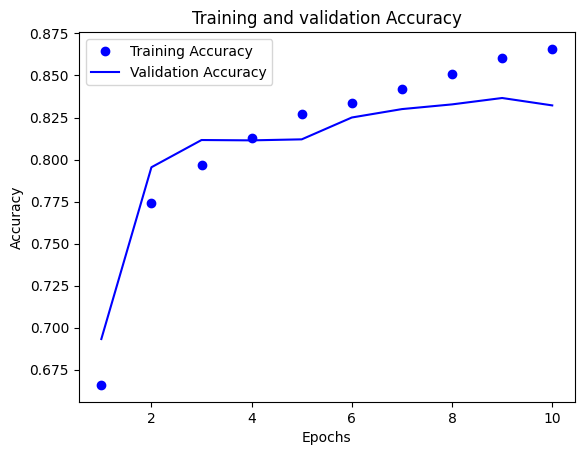

Training samples: 5000
Embedding layer test accuracy: 0.838
Pretrained embeddings test accuracy: 0.836
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 48s 68ms/step - loss: 0.5121 - accuracy: 0.7430 - val_loss: 0.3835 - val_accuracy: 0.8320
Epoch 2/10
625/625 [==============================] - 21s 33ms/step - loss: 0.3461 - accuracy: 0.8588 - val_loss: 0.4187 - val_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2941 - accuracy: 0.8831 - val_loss: 0.3717 - val_accuracy: 0.8412
Epoch 4/10
625/625 [==============================] - 36s 57ms/step - loss: 0.2623 - accuracy: 0.8985 - val_loss: 0.3656 - val_accuracy: 0.8488
Epoch 5/10
625/625 [==============================] - 19s 31ms/step - loss: 0.2323 - accuracy: 0.9119 - val_loss: 0.4102 - val_accuracy: 0.8332
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2074 -

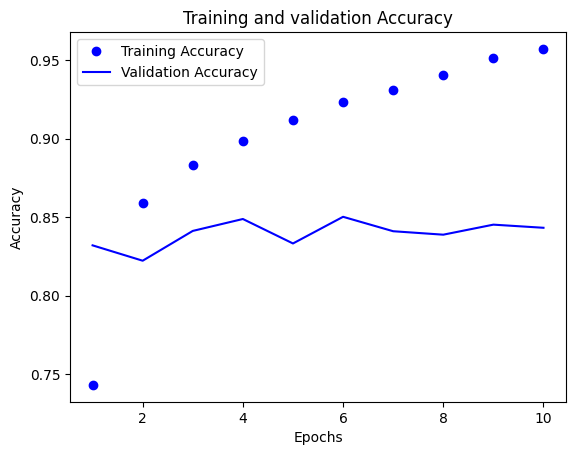

Epoch 1/10
625/625 [==============================] - 67s 89ms/step - loss: 0.5964 - accuracy: 0.6713 - val_loss: 0.4875 - val_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 51s 82ms/step - loss: 0.4917 - accuracy: 0.7688 - val_loss: 0.4587 - val_accuracy: 0.7794
Epoch 3/10
625/625 [==============================] - 47s 76ms/step - loss: 0.4413 - accuracy: 0.7957 - val_loss: 0.4436 - val_accuracy: 0.7956
Epoch 4/10
625/625 [==============================] - 46s 74ms/step - loss: 0.4169 - accuracy: 0.8106 - val_loss: 0.4149 - val_accuracy: 0.8106
Epoch 5/10
625/625 [==============================] - 56s 89ms/step - loss: 0.3904 - accuracy: 0.8236 - val_loss: 0.3888 - val_accuracy: 0.8230
Epoch 6/10
625/625 [==============================] - 18s 28ms/step - loss: 0.3740 - accuracy: 0.8338 - val_loss: 0.4113 - val_accuracy: 0.8104
Epoch 7/10
625/625 [==============================] - 51s 81ms/step - loss: 0.3600 - accuracy: 0.8431 - val_loss: 0.3859 - val_accuracy:

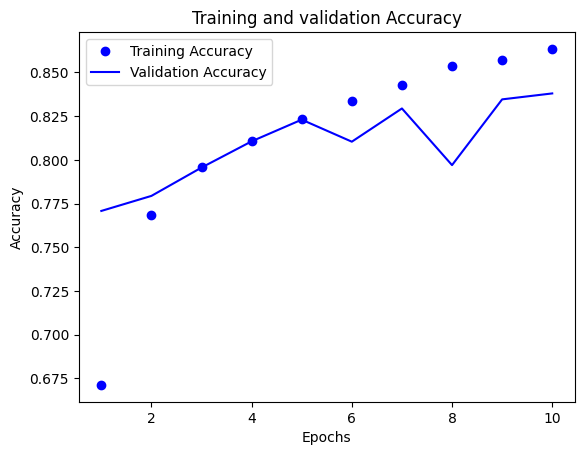

Training samples: 10000
Embedding layer test accuracy: 0.836
Pretrained embeddings test accuracy: 0.833
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 48s 68ms/step - loss: 0.5249 - accuracy: 0.7293 - val_loss: 0.4052 - val_accuracy: 0.8182
Epoch 2/10
625/625 [==============================] - 35s 55ms/step - loss: 0.3497 - accuracy: 0.8547 - val_loss: 0.3709 - val_accuracy: 0.8412
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.2936 - accuracy: 0.8820 - val_loss: 0.3611 - val_accuracy: 0.8420
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 0.2601 - accuracy: 0.9017 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 5/10
625/625 [==============================] - 18s 28ms/step - loss: 0.2327 - accuracy: 0.9121 - val_loss: 0.4071 - val_accuracy: 0.8380
Epoch 6/10
625/625 [==============================] - 15s 23ms/step - loss: 0.2064 

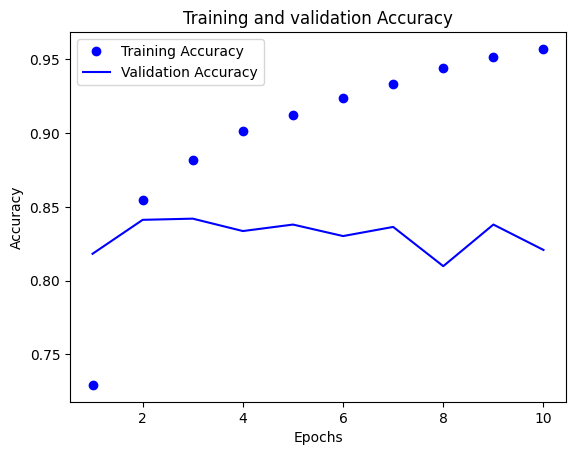

Epoch 1/10
625/625 [==============================] - 61s 78ms/step - loss: 0.5938 - accuracy: 0.6737 - val_loss: 0.4875 - val_accuracy: 0.7644
Epoch 2/10
625/625 [==============================] - 56s 89ms/step - loss: 0.4834 - accuracy: 0.7711 - val_loss: 0.4448 - val_accuracy: 0.7888
Epoch 3/10
625/625 [==============================] - 19s 30ms/step - loss: 0.4434 - accuracy: 0.7973 - val_loss: 0.4606 - val_accuracy: 0.7798
Epoch 4/10
625/625 [==============================] - 50s 80ms/step - loss: 0.4176 - accuracy: 0.8093 - val_loss: 0.4436 - val_accuracy: 0.7858
Epoch 5/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3950 - accuracy: 0.8215 - val_loss: 0.4152 - val_accuracy: 0.8100
Epoch 6/10
625/625 [==============================] - 47s 75ms/step - loss: 0.3785 - accuracy: 0.8337 - val_loss: 0.3919 - val_accuracy: 0.8214
Epoch 7/10
625/625 [==============================] - 48s 76ms/step - loss: 0.3599 - accuracy: 0.8420 - val_loss: 0.3823 - val_accuracy:

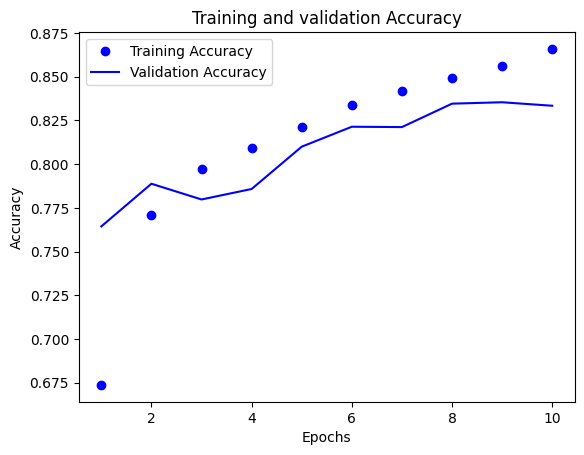

Training samples: 20000
Embedding layer test accuracy: 0.833
Pretrained embeddings test accuracy: 0.839
--------------------------------------------------


In [15]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = val_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_tokens, embedding_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.x")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(accuracy) + 1)
    plt.figure()
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        max_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.x")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(accuracy) + 1)
    plt.figure()
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)